# UTS

## SOAl NOMOR 1

Lakukan analisa klasifikasikan berita dengan extraksi fitur model topik modelling dengan classifier naïve bayes dan SVM

## Dataset

In [38]:
import pandas as pd

# Ganti path sesuai lokasi file kamu
df = pd.read_csv("Beritauts.csv")

# Melihat struktur data
print("Jumlah baris dan kolom:", df.shape)
print("\nNama kolom:", df.columns.tolist())

# Lihat 5 data pertama
df.head()


Jumlah baris dan kolom: (1500, 6)

Nama kolom: ['No', 'judul', 'berita', 'tanggal', 'kategori', 'link']


,No,judul,berita,tanggal,kategori,link
0,1,Airlangga Harap Kenaikan UMP Tingkatkan Daya B...,Menteri Koordinator (Menko) Bidang Perekonomia...,"Minggu, 01 Des 2024 23:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...
1,2,PT SIER Beri Penghargaan untuk 50 Tenant Terba...,"Dalam rangka memeriahkan hari jadi ke-50, PT S...","Minggu, 01 Des 2024 20:45 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412012...
2,3,Prabowo Bakal Bentuk Kementerian Penerimaan Ne...,Wacana Presiden Prabowo Subianto akan membentu...,"Minggu, 01 Des 2024 19:40 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
3,4,Sinergi Kemenag & BPJS Ketenagakerjaan Lindung...,BPJS Ketenagakerjaan dan Kementerian Agama (Ke...,"Minggu, 01 Des 2024 19:03 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...
4,5,Pemerintah Segera Bentuk Satgas PHK Usai Tetap...,Pemerintah akan segera membentuk Satuan Tugas ...,"Minggu, 01 Des 2024 19:00 WIB",Ekonomi,https://www.cnnindonesia.com/ekonomi/202412011...


## Preprocessing

In [39]:
!pip install Sastrawi nltk

In [40]:
import re
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Ambil stopword otomatis
stop_factory = StopWordRemoverFactory()
stop_id = set(stop_factory.get_stop_words())
stop_en = set(stopwords.words('english'))
stops = stop_id.union(stop_en)

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", " ", text)        # hapus URL
    text = re.sub(r"[^a-z\s]", " ", text)       # hapus simbol
    text = re.sub(r"\s+", " ", text).strip()    # hapus spasi berlebih
    tokens = [t for t in text.split() if t not in stops and len(t) > 2]
    return " ".join(tokens)

# Kolom teks dan label
text_col = "berita"
label_col = "kategori"

df["cleaned_text"] = df[text_col].apply(clean_text)

df[[text_col, "cleaned_text", label_col]].head(10)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,berita,cleaned_text,kategori
0,Menteri Koordinator (Menko) Bidang Perekonomia...,menteri koordinator menko bidang perekonomian ...,Ekonomi
1,"Dalam rangka memeriahkan hari jadi ke-50, PT S...",rangka memeriahkan hari jadi surabaya industri...,Ekonomi
2,Wacana Presiden Prabowo Subianto akan membentu...,wacana presiden prabowo subianto membentuk mem...,Ekonomi
3,BPJS Ketenagakerjaan dan Kementerian Agama (Ke...,bpjs ketenagakerjaan kementerian agama kemenag...,Ekonomi
4,Pemerintah akan segera membentuk Satuan Tugas ...,pemerintah segera membentuk satuan tugas pemut...,Ekonomi
5,Menko Bidang Infrastruktur dan Pembangunan Kew...,menko bidang infrastruktur pembangunan kewilay...,Ekonomi
6,Kepala Badan Gizi Nasional Dadan Hindayana men...,kepala badan gizi nasional dadan hindayana men...,Ekonomi
7,Menteri Koordinator Bidang Pangan Zulkifli Has...,menteri koordinator bidang pangan zulkifli has...,Ekonomi
8,Uji coba alias commissioning pembangkit listri...,uji coba alias commissioning pembangkit listri...,Ekonomi
9,Anak crazy rich pengusaha sawit Kalimantan Sam...,anak crazy rich pengusaha sawit kalimantan sam...,Ekonomi


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
No charts were generated by quickchart


# Topik Modelling LDA

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

count_vec = CountVectorizer(max_df=0.95, min_df=5)
dtm = count_vec.fit_transform(df["cleaned_text"])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
doc_topic = lda.fit_transform(dtm)

# tampilkan topik
feature_names = count_vec.get_feature_names_out()
n_top_words = 5
for idx, topic in enumerate(lda.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topik {idx+1}: {', '.join(top_words)}")

Topik 1: laut, pagar, tersebut, jakarta, tangerang
Topik 2: indonesia, timnas, pemain, piala, gol
Topik 3: indonesia, persen, program, negara, tahun
Topik 4: tersebut, kasus, presiden, kpk, kata
Topik 5: israel, gaza, senjata, gencatan, orang


## Membagi Data & Encodel Label

In [42]:
import numpy as np
import pandas as pd

# Menentukan topik paling dominan di setiap dokumen
dominant_topic = np.argmax(doc_topic, axis=1)

# Tambahkan kolom topik dominan ke dataframe asli
df["topik_dominan"] = dominant_topic + 1  # +1 biar topiknya mulai dari 1 bukan 0

# Tampilkan 5 berita pertama beserta topik dominannya
df[["cleaned_text", "topik_dominan"]].head(5)


,cleaned_text,topik_dominan
0,menteri koordinator menko bidang perekonomian ...,3
1,rangka memeriahkan hari jadi surabaya industri...,3
2,wacana presiden prabowo subianto membentuk mem...,3
3,bpjs ketenagakerjaan kementerian agama kemenag...,3
4,pemerintah segera membentuk satuan tugas pemut...,1


In [46]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# --- 1. Jika dataset kamu sudah ada kolom kategori ---
# (misalnya kolom bernama 'kategori' berisi: politik, ekonomi, olahraga, dll)
# Maka encode labelnya begini:
le = LabelEncoder()
df["label_encoded"] = le.fit_transform(df["kategori"])

# --- 2. Jika TIDAK ADA kolom kategori ---
# dan kamu mau pakai topik_dominan dari LDA sebagai label sementara:
# df["label_encoded"] = df["topik_dominan"]

# --- 3. Siapkan fitur dan label ---
X = doc_topic               # fitur dari hasil topic modeling (LDA)
y = df["label_encoded"]     # label hasil encoding

# --- 4. Bagi data menjadi training dan testing ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,          # 20% data untuk pengujian, 80% untuk pelatihan
    random_state=42,        # biar hasil konsisten setiap dijalankan
    stratify=y              # biar proporsi label tetap seimbang di train dan test
)

# --- 5. Cek hasil pembagian ---
print("Jumlah total data:", len(y))
print("Jumlah data training:", len(y_train))
print("Jumlah data testing:", len(y_test))
print("\nPersentase data training: {:.2f}%".format(len(y_train)/len(y)*100))
print("Persentase data testing: {:.2f}%".format(len(y_test)/len(y)*100))

# --- 6. (Opsional) Lihat contoh hasil encoding ---
print("\nKategori unik:", le.classes_ if 'le' in locals() else "topik_dominan")
df[["cleaned_text", "label_encoded"]].head()


Jumlah total data: 1500
Jumlah data training: 1200
Jumlah data testing: 300

Persentase data training: 80.00%
Persentase data testing: 20.00%

Kategori unik: ['Ekonomi' 'Internasional' 'Nasional' 'Olahraga']


,cleaned_text,label_encoded
0,menteri koordinator menko bidang perekonomian ...,0
1,rangka memeriahkan hari jadi surabaya industri...,0
2,wacana presiden prabowo subianto membentuk mem...,0
3,bpjs ketenagakerjaan kementerian agama kemenag...,0
4,pemerintah segera membentuk satuan tugas pemut...,0


## Klasifikasi

In [47]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report

# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
nb_pred = nb.predict(X_test)

# SVM
svm = LinearSVC(random_state=42, max_iter=10000)
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)

# Evaluasi
print("=== Multinomial Naïve Bayes ===")
print("Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred, target_names=le.classes_))

print("=== Linear SVM ===")
print("Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred, target_names=le.classes_))


=== Multinomial Naïve Bayes ===
Accuracy: 0.82
               precision    recall  f1-score   support

      Ekonomi       0.81      0.97      0.88        75
Internasional       0.76      0.75      0.75        75
     Nasional       0.69      0.56      0.62        75
     Olahraga       1.00      1.00      1.00        75

     accuracy                           0.82       300
    macro avg       0.81      0.82      0.81       300
 weighted avg       0.81      0.82      0.81       300

=== Linear SVM ===
Accuracy: 0.8266666666666667
               precision    recall  f1-score   support

      Ekonomi       0.79      0.99      0.88        75
Internasional       0.79      0.75      0.77        75
     Nasional       0.72      0.57      0.64        75
     Olahraga       1.00      1.00      1.00        75

     accuracy                           0.83       300
    macro avg       0.82      0.83      0.82       300
 weighted avg       0.82      0.83      0.82       300



## Confusion Matriks

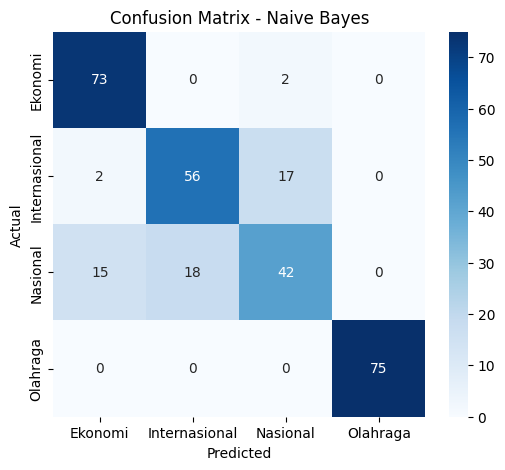

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Naive Bayes
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, nb_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# SVM
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, svm_pred), annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


## SOAL NOMOR 2

Lakukan  analisa clutering dokumen pada data email berikut

In [29]:
import pandas as pd

# Coba beberapa encoding umum untuk menghindari error UnicodeDecodeError
try:
    df = pd.read_csv("spamuts.csv", encoding="utf-8")
except UnicodeDecodeError:
    try:
        df = pd.read_csv("spamuts.csv", encoding="latin-1")
    except UnicodeDecodeError:
        df = pd.read_csv("spamuts.csv", encoding="windows-1252")

# Tampilkan beberapa baris pertama
print("=== 5 Baris Pertama Dataset ===")
print(df.head())

# Tampilkan struktur dataset
print("\n=== Informasi Dataset ===")
print(df.info())


=== 5 Baris Pertama Dataset ===
   id                                               Text Unnamed: 2  \
0   1  Go until jurong point, crazy.. Available only ...        NaN   
1   2                      Ok lar... Joking wif u oni...        NaN   
2   3  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   4  U dun say so early hor... U c already then say...        NaN   
4   5  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  

=== Informasi Dataset ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5572 non-null   int64 
 1   Text        5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed